In [37]:
# Aca resolvemos una ODE con condición inicial
# Problema 6 del articulo
# Artificial Neural Networks for Solving Ordinary and Partial Differential Equations

importamos los paquetes necesarios para el entrenamiento

In [38]:

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

Se resuelve la ecuación diferencial 

\begin{align}
\nabla^2 \psi(x,y) = (2 - \pi^2y^2)\sin(\pi x)
\end{align}

definición de la arquitectura de la red neuronal

In [39]:
N = nn.Sequential(
    nn.Linear(2,64),
    nn.Sigmoid(),
    nn.Linear(64,128),
    nn.Sigmoid(),
    nn.Linear(128,256),
    nn.Sigmoid(),
    nn.Linear(256,512),
    nn.Sigmoid(),
    nn.Linear(512,1024),
    nn.Sigmoid(),
    nn.Linear(1024,512),
    nn.Sigmoid(),
    nn.Linear(512,256),
    nn.Sigmoid(),
    nn.Linear(256,128),
    nn.Sigmoid(),
    nn.Linear(128,64),
    nn.Sigmoid(),
    nn.Linear(64,32),
    nn.Sigmoid(),
    nn.Linear(32,1, bias=False))

### Red de prueba

In [40]:
f0 = lambda y: 0
f1 = lambda y: 0
g0 = lambda x: 0
g1 = lambda x: 2*torch.sin(torch.pi*x)

B = lambda x, y: ((1 - x)*f0(y) + x*f1(y) + g0(x)
                  - ((1 - x)*g0(0) + x*g0(torch.tensor(1.0)))
                  + y*(g1(x) - ((1 - x)*g1(torch.tensor(0)) + x*g1(torch.tensor(1.0)))))


# Psi_estimate = lambda x, y, N_x1, dN_x1: B(x, y) + x*(1 - x)*y*(1 - y)*(N(torch.stack((x, y), dim=1)) - N(torch.stack((x, torch.ones_like(x)), dim=1)))

def Psi_estimate(x,y):
    x.requires_grad = True
    y.requires_grad = True
    N_x1 = N(torch.stack((x, torch.ones_like(x)), dim=1))
    N_xy = N(torch.stack((x, y), dim=1))
    dN_x1 = torch.autograd.grad(N_xy, y, torch.ones_like(N_x1), create_graph=True)[0]
    return B(x, y) + x*(1 - x)*y*(1 - y)*(N(torch.stack((x, y), dim=1)) - N_x1 - dN_x1)

In [41]:
# ahora definimos la función f(.)
f = lambda x, y: (2 - torch.pi**2*y**2)*torch.sin(torch.pi*x)

In [42]:
def loss(x, y):
    x.requires_grad = True
    y.requires_grad = True
    # N_x1 = N(torch.stack((x, torch.ones_like(x)), dim=1))
    # dN_x1 = torch.autograd.grad(N_x1, x, grad_outputs=torch.ones_like(N_x1), create_graph=True, allow_unused=True)[0]
    outputs = Psi_estimate(x, y)
    Psi_estimate_x = torch.autograd.grad(outputs,x, grad_outputs=torch.ones_like(outputs),create_graph=True)[0] # esta es la derivada de Psi con respecto a x, i.e., dPsi/dx
    dPsi_estimate_x = torch.autograd.grad(Psi_estimate_x,x, grad_outputs=torch.ones_like(Psi_estimate_x),create_graph=True)[0] # esta es la derivada de dPsi/dx con respecto a x, i.e., d^2Psi/dx^2
    Psi_estimate_y = torch.autograd.grad(outputs,y, grad_outputs=torch.ones_like(outputs),create_graph=True)[0] # esta es la derivada de Psi con respecto a y, i.e., dPsi/dy
    dPsi_estimate_y = torch.autograd.grad(Psi_estimate_y,y, grad_outputs=torch.ones_like(Psi_estimate_y),create_graph=True)[0] # esta es la derivada de dPsi/dy con respecto a y, i.e., d^2Psi/dy^2
    return torch.mean((dPsi_estimate_x + dPsi_estimate_y - f(x, y))**2)


In [43]:
optimizer = torch.optim.LBFGS(N.parameters())

In [44]:
x = torch.linspace(0, 1, 10)
y = torch.linspace(0, 1, 10)
 

In [45]:
def closure():
    optimizer.zero_grad()
    l = loss(x, y)
    l.backward()
    return l

for i in range(50):
    optimizer.step(closure)

### Comparación de resultados

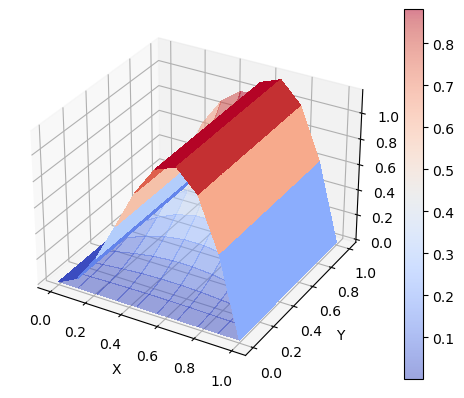

In [46]:
xx = np.linspace(0, 1, 10)
yy = np.linspace(0, 1, 10)

XX, YY = np.meshgrid(xx, yy)
yt = YY**2*np.sin(np.pi*XX)

y_estimate = Psi_estimate(torch.Tensor(xx), torch.Tensor(yy)).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(XX, YY, y_estimate, cmap='coolwarm', linewidth=0, antialiased=False)
surf = ax.plot_surface(XX, YY, yt, cmap='coolwarm', linewidth=0, antialiased=False, alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
fig.colorbar(surf)